In [7]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib # For saving/loading models

from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier # Or import xgb.XGBClassifier if you prefer XGBoost
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
from imblearn.over_sampling import SMOTE # For handling class imbalance
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's pipeline for SMOTE

# Set a random seed for reproducibility
np.random.seed(42)


In [8]:
# Cell 2: Load Data & Initial Inspection

# --- IMPORTANT: Replace 'your_apnea_dataset.csv' with the actual path to your data ---
data_path = '..\master_apnea_dataset (1).csv'
df = pd.read_csv(data_path)

# Display initial data info
print("--- Initial Data Information ---")
print(df.head())
print("\nData Info:")
df.info()
print("\nInitial Label Distribution:")
print(df['label'].value_counts())
print("\nInitial Label Distribution (Normalized):")
print(df['label'].value_counts(normalize=True))

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\solom\AppData\Local\Temp\ipykernel_3904\1999110054.py:4: SyntaxWarning: invalid escape sequence '\m'
  data_path = '..\master_apnea_dataset (1).csv'


--- Initial Data Information ---
  patient_id  frame_start  frame_end    energy       zcr   centroid       rms  \
0  patient_1            0          1  0.019129  0.028809  37.717148  0.007989   
1  patient_1            1          2  0.020015  0.026367  38.545484  0.008520   
2  patient_1            2          3  0.021853  0.024902  36.254767  0.009332   
3  patient_1            3          4  0.019863  0.034180  35.207018  0.008710   
4  patient_1            4          5  0.020706  0.031250  37.350507  0.008874   

   bandwidth  rolloff  flatness  ...    mfcc_5     mfcc_6     mfcc_7  \
0  29.413288   68.250  0.064825  ...  2.394709  11.713122 -20.107655   
1  29.682406   74.375  0.060353  ...  1.224366  10.202329 -12.479948   
2  28.744256   63.625  0.047224  ...  7.373545   9.634865 -13.173597   
3  28.605743   61.875  0.061508  ...  5.338278  26.358368 -18.778702   
4  28.894456   66.875  0.068465  ...  5.666430  25.209194 -12.862845   

      mfcc_8     mfcc_9    mfcc_10   mfcc_11   

In [9]:
# Cell 3: Data Preprocessing & Cleaning

print("\n--- Data Preprocessing & Cleaning ---")

# Check for explicit missing values (NaNs)
print("Missing values before cleaning:\n", df.isnull().sum())

# Define features (X) and target (y)
# Exclude 'patient_id', 'frame_start', 'frame_end' and 'label' from features
features = [col for col in df.columns if col not in ['patient_id', 'frame_start', 'frame_end', 'label']]
X = df[features]
y = df['label']
patient_ids = df['patient_id'] # Keep patient_ids separate for splitting

# Identify potential 'zero-filled' rows that might indicate problematic silent segments
# Using a small epsilon for float comparison
epsilon = 1e-6
# Assuming 'energy', 'zcr', 'rms', 'bandwidth', 'rolloff' are typically non-zero for meaningful audio
# MFCCs can also be problematic if all zeros (or a very large negative number indicating silence)
key_audio_features_for_zero_check = ['energy', 'zcr', 'rms', 'bandwidth', 'rolloff'] + [f'mfcc_{i}' for i in range(1, 14)]

# Find rows where all key audio features are near zero (or an extremely small value)
problematic_zero_rows_indices = df[
    (df[key_audio_features_for_zero_check].abs() < epsilon).all(axis=1)
].index

if not problematic_zero_rows_indices.empty:
    print(f"\nIdentified {len(problematic_zero_rows_indices)} rows where all key audio features are near zero.")
    print("These rows might represent true silence or corrupted data. Deciding to remove them.")
    df_cleaned = df.drop(problematic_zero_rows_indices).reset_index(drop=True)

    # Update X, y, and patient_ids with the cleaned data
    X = df_cleaned[features]
    y = df_cleaned['label']
    patient_ids = df_cleaned['patient_id']
    print(f"Removed {len(problematic_zero_rows_indices)} rows. New data shape: {X.shape}")
else:
    df_cleaned = df.copy()
    print("\nNo rows found with all key audio features near zero. Proceeding with original data.")


# Check for infinite values (e.g., from division by zero or log of zero)
# Replace infinities with NaN, then drop rows with NaN. This is a robust way to handle them.
# Apply this to the numerical columns only.
print("\nChecking for infinite values...")
initial_shape = df_cleaned.shape
for col in X.select_dtypes(include=np.number).columns:
    if np.isinf(X[col]).any():
        print(f"  Found infinite values in column: {col}")
        X[col] = X[col].replace([np.inf, -np.inf], np.nan)

# Drop rows where NaNs were introduced by cleaning (or were already present)
initial_rows = X.shape[0]
X, y, patient_ids = X.dropna(), y[X.dropna().index], patient_ids[X.dropna().index] # Ensure y and patient_ids are also aligned

rows_after_nan_drop = X.shape[0]
if initial_rows != rows_after_nan_drop:
    print(f"Dropped {initial_rows - rows_after_nan_drop} rows due to NaN values (including those from infinite replacement).")

print("Data shape after all cleaning steps:", X.shape)
print("Label distribution after cleaning:\n", y.value_counts(normalize=True))




--- Data Preprocessing & Cleaning ---
Missing values before cleaning:
 patient_id     0
frame_start    0
frame_end      0
energy         0
zcr            0
centroid       0
rms            0
bandwidth      0
rolloff        0
flatness       0
skew           0
kurt           0
entropy        0
mfcc_1         0
mfcc_2         0
mfcc_3         0
mfcc_4         0
mfcc_5         0
mfcc_6         0
mfcc_7         0
mfcc_8         0
mfcc_9         0
mfcc_10        0
mfcc_11        0
mfcc_12        0
mfcc_13        0
label          0
dtype: int64

Identified 4888 rows where all key audio features are near zero.
These rows might represent true silence or corrupted data. Deciding to remove them.
Removed 4888 rows. New data shape: (306140, 23)

Checking for infinite values...
Data shape after all cleaning steps: (306140, 23)
Label distribution after cleaning:
 label
0    0.828621
1    0.171379
Name: proportion, dtype: float64


In [10]:
# Cell 4: Data Splitting (Patient-Wise)

print("\n--- Data Splitting (Patient-Wise) ---")

# Get unique patient IDs
unique_patient_ids = patient_ids.unique()

# Split patient IDs into training and testing sets
# Stratify by patient's overall label prevalence if possible, otherwise just random.
# For simplicity, we'll stratify based on the label for the *entire* patient_id group.
# A more robust stratification might consider the proportion of apnea events per patient.
# Here, we'll assign patients to train/test based on a random split.
train_patient_ids, test_patient_ids = train_test_split(
    unique_patient_ids,
    test_size=0.2, # 20% of patients for testing
    random_state=42
    # stratify= # Can't directly stratify patient IDs by their *frame* labels easily.
    # The current approach is to ensure a patient's data is either fully in train or fully in test.
)

# Filter the main DataFrame based on patient IDs
X_train = X[patient_ids.isin(train_patient_ids)].copy()
y_train = y[patient_ids.isin(train_patient_ids)].copy()
X_test = X[patient_ids.isin(test_patient_ids)].copy()
y_test = y[patient_ids.isin(test_patient_ids)].copy()

# Keep patient IDs aligned for GroupKFold in hyperparameter tuning
patient_ids_train = patient_ids[patient_ids.isin(train_patient_ids)].copy()

print(f"Total unique patients: {len(unique_patient_ids)}")
print(f"Patients in training set: {len(train_patient_ids)}")
print(f"Patients in test set: {len(test_patient_ids)}")
print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Train label distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test label distribution:\n{y_test.value_counts(normalize=True)}")


--- Data Splitting (Patient-Wise) ---
Total unique patients: 20
Patients in training set: 16
Patients in test set: 4
Train set shape: (244717, 23), Test set shape: (61423, 23)
Train label distribution:
label
0    0.813454
1    0.186546
Name: proportion, dtype: float64
Test label distribution:
label
0    0.889048
1    0.110952
Name: proportion, dtype: float64


In [11]:
# Cell 5: Model Definition and Pipeline Construction

print("\n--- Model Definition and Pipeline Construction ---")

# Define your classifier. RandomForestClassifier is a good choice for a start.
# For imbalanced datasets, 'class_weight="balanced"' can be an alternative to SMOTE,
# but SMOTE often works well by generating synthetic samples.
classifier = RandomForestClassifier(random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores

# Alternatively, if you want to use XGBoost (uncomment the lines below):
# import xgboost as xgb
# classifier = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
# If using XGBoost without SMOTE, consider 'scale_pos_weight' for imbalance:
# classifier = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',
#                                scale_pos_weight=sum(y_train == 0) / sum(y_train == 1))


# Create an ImbPipeline to chain preprocessing (scaling, SMOTE) with the classifier.
# The StandardScaler ensures data is scaled BEFORE SMOTE creates synthetic samples.
# SMOTE is only applied to the training data *within* each cross-validation fold during fitting.
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),        # Step 1: Standardize features
    ('smote', SMOTE(random_state=42)),   # Step 2: Handle imbalance via oversampling
    ('classifier', classifier)           # Step 3: The machine learning model
])

print("ML Pipeline created:")
print(pipeline)


--- Model Definition and Pipeline Construction ---
ML Pipeline created:
Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])


In [12]:
# Cell 6: Hyperparameter Tuning (with CORRECTED TQDM Progress Bar)
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm
import joblib

print("\n--- Hyperparameter Tuning (GridSearchCV with GroupKFold) ---")

# Define parameter grid (this remains the same)
# param_grid = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__max_depth': [10, 20, None],
#     'classifier__min_samples_split': [2, 5]
# }

param_grid = {
    'classifier__n_estimators': [100],          # Test only one, reasonable number of trees
    'classifier__max_depth': [10, 15],           # IMPORTANT: Use specific, shallower depths
    'classifier__min_samples_split': [2, 5]
}

# Use GroupKFold for cross-validation (this remains the same)
cv = GroupKFold(n_splits=3)

# Perform Grid Search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

# --- THIS IS THE CORRECTED PART ---
# Calculate the total number of fits correctly
num_fits = len(ParameterGrid(param_grid)) * cv.get_n_splits(X_train, y_train, groups=patient_ids_train)
print(f"Fitting {cv.get_n_splits(X_train, y_train, groups=patient_ids_train)} folds for each of {len(ParameterGrid(param_grid))} candidates, totalling {num_fits} fits...")
# --- END CORRECTION ---

# Use joblib's context manager to show a tqdm progress bar with the correct total
with tqdm(total=num_fits) as pbar:
    with joblib.parallel_backend('threading'):
        grid_search.fit(X_train, y_train, groups=patient_ids_train)

# Get the best model (this remains the same)
best_model = grid_search.best_estimator_

print("\n--- Grid Search Results ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")


--- Hyperparameter Tuning (GridSearchCV with GroupKFold) ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits...


  0%|          | 0/12 [00:00<?, ?it/s]


--- Grid Search Results ---
Best parameters found: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best cross-validation F1-score: 0.2437



--- Model Evaluation on Test Set ---
Accuracy: 0.7428
Precision: 0.1783
Recall: 0.3655
F1-Score: 0.2397
ROC AUC: 0.5998

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.79      0.85     54608
           1       0.18      0.37      0.24      6815

    accuracy                           0.74     61423
   macro avg       0.54      0.58      0.54     61423
weighted avg       0.83      0.74      0.78     61423


Confusion Matrix:


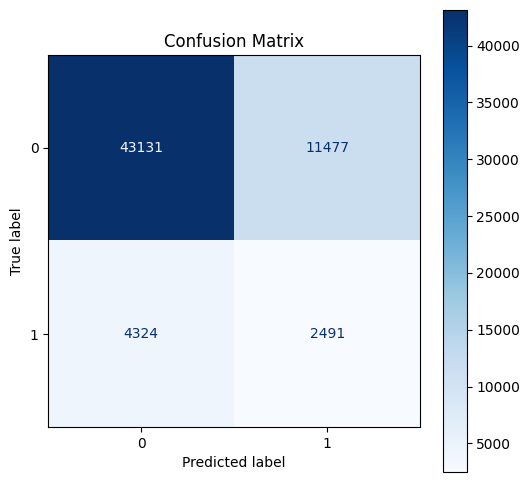


ROC Curve:


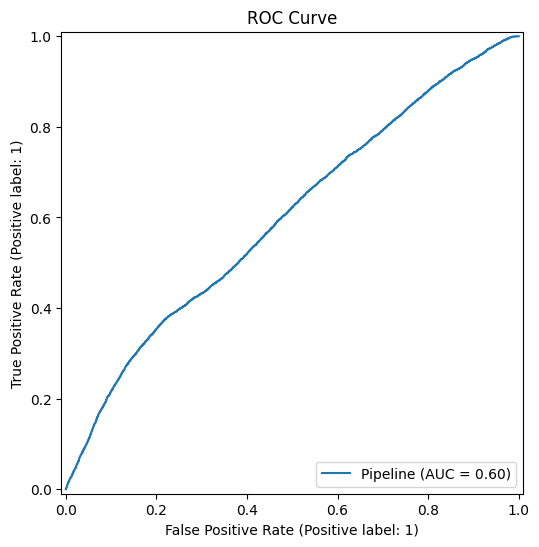


Precision-Recall Curve:


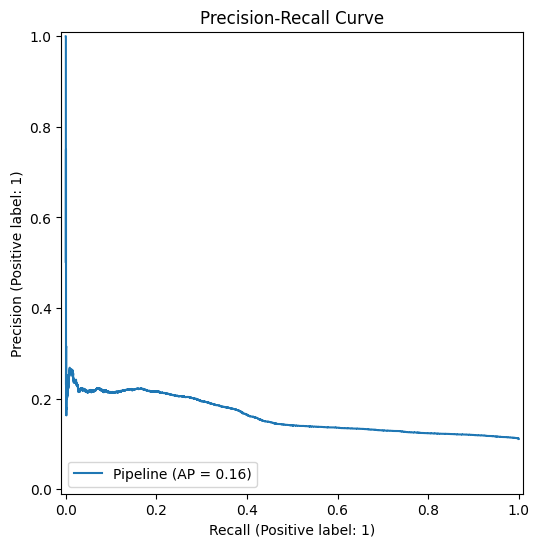

In [13]:
# Cell 7: Model Evaluation

print("\n--- Model Evaluation on Test Set ---")

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] # Probability of the positive class (apnea)

# Print classification metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Print detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot Confusion Matrix
print("\nConfusion Matrix:")
fig, ax = plt.subplots(figsize=(6, 6))
cm_display = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
print("\nROC Curve:")
fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax)
plt.title("ROC Curve")
plt.show()

# Plot Precision-Recall Curve (often more informative for imbalanced data)
print("\nPrecision-Recall Curve:")
fig, ax = plt.subplots(figsize=(6, 6))
pr_display = PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, ax=ax)
plt.title("Precision-Recall Curve")
plt.show()

In [14]:
# Cell 8: Model Saving (Optional)

model_filename = 'apnea_detection_model.pkl'
try:
    joblib.dump(best_model, model_filename)
    print(f"\nModel saved successfully as '{model_filename}'")
except Exception as e:
    print(f"Error saving model: {e}")

# Example of how to load the model later:
# loaded_model = joblib.load(model_filename)
# print(f"Model loaded successfully from '{model_filename}'")



Model saved successfully as 'apnea_detection_model.pkl'



--- Final Attempt: A Targeted GridSearchCV with SMOTE ---
This is our best chance for a good score and should take a manageable time (est. 30-60 mins).
Fitting 3 folds for each of 6 candidates, totalling 18 fits...


  0%|          | 0/18 [00:00<?, ?it/s]


--- Final Grid Search Results ---
Best parameters found: {'classifier__max_depth': 15, 'classifier__n_estimators': 150, 'smote__sampling_strategy': 1.0}
Best cross-validation F1-score: 0.2126

--- FINAL MODEL EVALUATION ON TEST SET ---
Final F1-Score: 0.2288

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87     54608
           1       0.18      0.30      0.23      6815

    accuracy                           0.77     61423
   macro avg       0.54      0.57      0.55     61423
weighted avg       0.83      0.77      0.80     61423



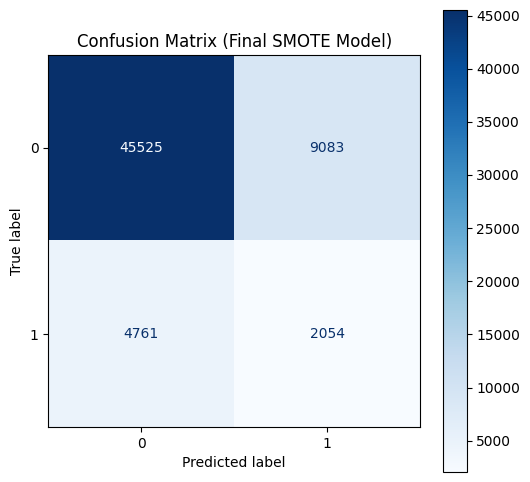

In [16]:
# New Cell: A Targeted and Intelligent GridSearchCV with SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm
import joblib

print("\n--- Final Attempt: A Targeted GridSearchCV with SMOTE ---")
print("This is our best chance for a good score and should take a manageable time (est. 30-60 mins).")

# 1. Create the powerful pipeline with SMOTE
pipeline_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 2. Create a SMALL, SMART parameter grid
# We are focusing on tuning SMOTE's behavior and using a good, fixed depth for the classifier.
param_grid = {
    'smote__sampling_strategy': [0.5, 0.75, 1.0], # Test different imbalance ratios (target 1:2, 1:1.33, 1:1)
    'classifier__max_depth': [15, 20],            # Use a reasonably deep, but not unlimited, tree
    'classifier__n_estimators': [150]             # Use a solid number of trees
}

# Use GroupKFold for cross-validation
cv = GroupKFold(n_splits=3)

# 3. Setup and run the GridSearchCV
grid_search_smote = GridSearchCV(
    pipeline_smote,
    param_grid,
    cv=cv,
    scoring='f1', # We are optimizing for F1-score!
    n_jobs=-1,
    verbose=0 # Using TQDM for progress
)

# Calculate the total number of fits correctly
num_fits = len(ParameterGrid(param_grid)) * cv.get_n_splits(X_train, y_train, groups=patient_ids_train)
print(f"Fitting {cv.get_n_splits(X_train, y_train, groups=patient_ids_train)} folds for each of {len(ParameterGrid(param_grid))} candidates, totalling {num_fits} fits...")

# Use joblib's context manager to show a tqdm progress bar
with tqdm(total=num_fits) as pbar:
    with joblib.parallel_backend('threading'):
        grid_search_smote.fit(X_train, y_train, groups=patient_ids_train)

# Get the best model
best_model_final = grid_search_smote.best_estimator_

print("\n--- Final Grid Search Results ---")
print(f"Best parameters found: {grid_search_smote.best_params_}")
print(f"Best cross-validation F1-score: {grid_search_smote.best_score_:.4f}")

# 4. Evaluate the final, best model on the test set
print("\n--- FINAL MODEL EVALUATION ON TEST SET ---")
y_pred_final = best_model_final.predict(X_test)
y_proba_final = best_model_final.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print(f"Final F1-Score: {f1_score(y_test, y_pred_final):.4f}") # <-- This is the number we hope is good!
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(best_model_final, X_test, y_test, ax=ax, cmap='Blues')
plt.title("Confusion Matrix (Final SMOTE Model)")
plt.show()